In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from IPython.display import display
from sklearn.model_selection import (GridSearchCV, ParameterGrid,
                                     RandomizedSearchCV)
from xgboost import XGBClassifier
import pickle
import random
from tqdm.notebook import trange, tqdm

from tools import Modelisation, datasets, SearchCV, restauration_CV, graph_2scores_CV, graph_param_CV, best_score_CV

t = time.time()

In [2]:
df = pd.read_csv('data/df_train_prepro.csv').sample(frac=1)
df.shape

(1610494, 48)

**Définition des variables quantitatives, des variables catégorielles et des datasets :**

In [3]:
datasets_df = datasets(df)
X_quant = datasets_df['X_quant']
X_cat = datasets_df['X_cat']
X = datasets_df['X']
y = datasets_df['y']

Columns_quant :


['contextid',
 'campaignctrlast24h',
 'dayssincelastvisitdouble',
 'ltf_nbglobaldisplay_4w',
 'ltf_nbpartnerdisplayssincelastclick',
 'ltf_nbpartnerdisplay_90d',
 'ltf_nbpartnerclick_90d',
 'ltf_nbpartnersales_90d',
 'nbdayssincelastclick',
 'nbdisplay_1hour',
 'nbdisplayglobalapprox_1d_sum_xdevice',
 'display_size',
 'zonecostineuro']


Columns_cat :


['display_env',
 'target_env',
 'campaignscenario',
 'campaignvertical',
 'is_interstitial',
 'device_type',
 'hour',
 'weekday']


Nombre de variables pour X_quant : 13



Index(['contextid', 'campaignctrlast24h', 'dayssincelastvisitdouble',
       'ltf_nbglobaldisplay_4w', 'ltf_nbpartnerdisplayssincelastclick',
       'ltf_nbpartnerdisplay_90d', 'ltf_nbpartnerclick_90d',
       'ltf_nbpartnersales_90d', 'nbdayssincelastclick', 'nbdisplay_1hour',
       'nbdisplayglobalapprox_1d_sum_xdevice', 'display_size',
       'zonecostineuro'],
      dtype='object')


Nombre de variables pour X_cat : 50



Index(['display_env_app_ios', 'display_env_other', 'display_env_web',
       'target_env_2', 'campaignscenario_5', 'campaignscenario_6',
       'campaignscenario_11', 'campaignscenario_12', 'campaignscenario_13',
       'campaignscenario_17', 'campaignvertical_20.0', 'campaignvertical_23.0',
       'campaignvertical_129.0', 'campaignvertical_200002.0',
       'is_interstitial_True', 'device_type_Desktop',
       'device_type_Desktop - Safari', 'device_type_Mobile - Other',
       'device_type_Unknown', 'device_type_iPad', 'device_type_iPhone',
       'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7',
       'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
       'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19',
       'hour_20', 'hour_21', 'hour_22', 'hour_23', 'weekday_Monday',
       'weekday_Saturday', 'weekday_Sunday', 'weekday_Thursday',
       'weekday_Tuesday', 'weekday_Wednesday'],
      dtype='object')


Nombre de variables pour X : 63


In [4]:
len(y[y == 0]) / (len(y[y == 1]))

16.552685500043594

# XGBoost
## Variables quantitatives

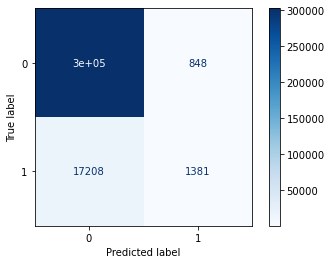

f1 : 0.1327
recall : 0.0743
negative predictive value : 0.9462
precision : 0.6196
roc_auc : 0.8269
Wall time: 26.9 s


In [5]:
%%time
m = Modelisation(X_quant, y, XGBClassifier(n_jobs=-1), scaling=False)
m.show_conf_matrix()
m.show_metrics_score()

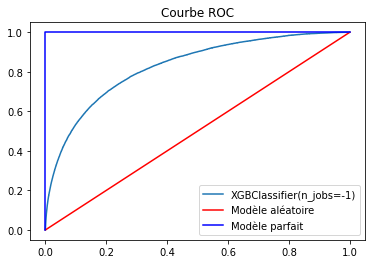

In [6]:
m.show_ROC()

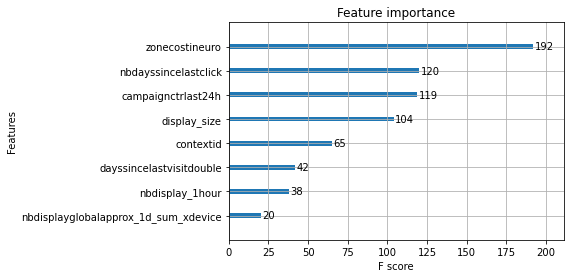

In [7]:
m.plot_importance()

Affichage d'un arbre (par défaut le premier parmi les autres) :

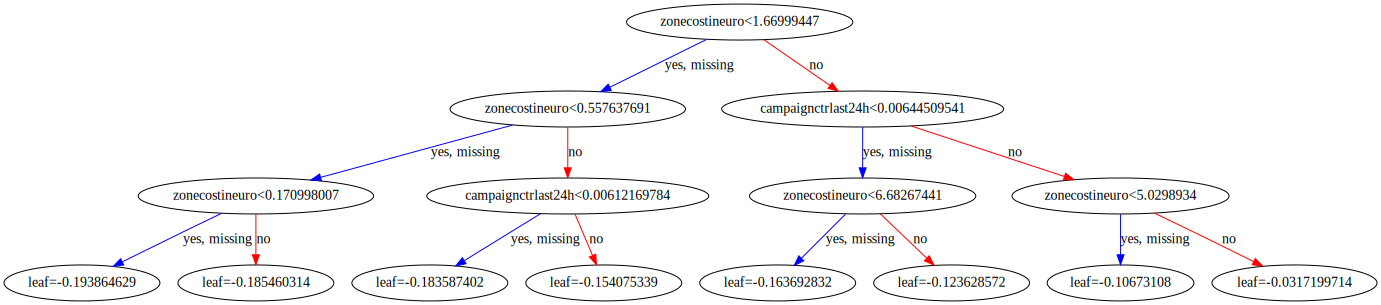

In [8]:
m.show_graph()

## Variables catégorielles

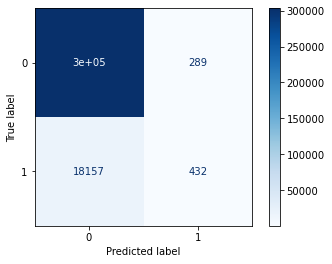

f1 : 0.0447
recall : 0.0232
negative predictive value : 0.9435
precision : 0.5992
roc_auc : 0.6908
Wall time: 45.8 s


In [9]:
%%time
m = Modelisation(X_cat, y, XGBClassifier(n_jobs=-1), scaling=False)
m.show_conf_matrix()
m.show_metrics_score()

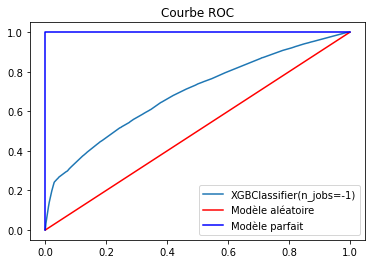

In [10]:
m.show_ROC()

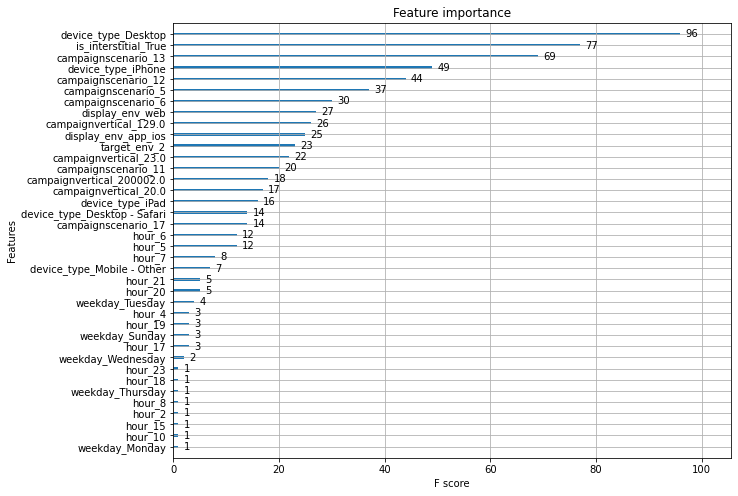

In [11]:
fig, ax = plt.subplots(figsize=(10, 8))
m.plot_importance(ax=ax)

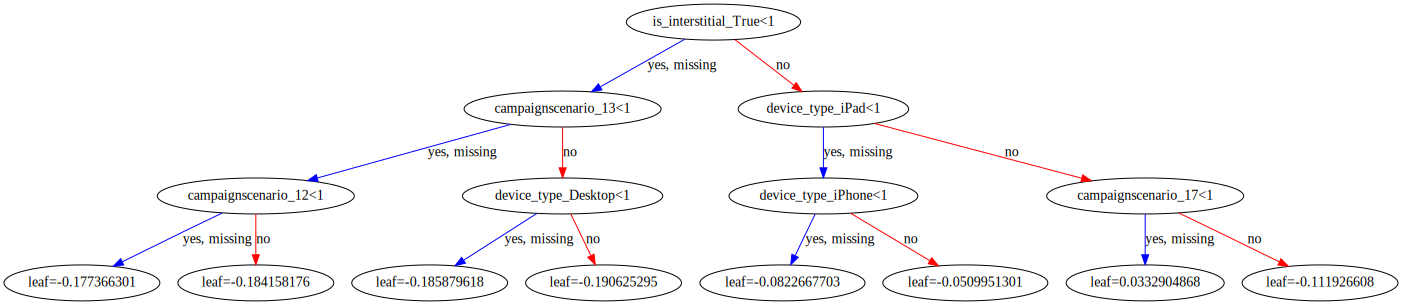

In [12]:
m.show_graph()

## Variables quantitatives + catégorielles

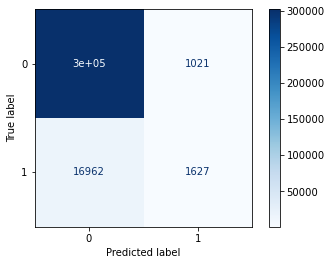

f1 : 0.1532
recall : 0.0875
negative predictive value : 0.9469
precision : 0.6144
roc_auc : 0.8337
Wall time: 1min 8s


In [13]:
%%time
m = Modelisation(X, y, XGBClassifier(n_jobs=-1), scaling=False)
m.show_conf_matrix()
m.show_metrics_score()

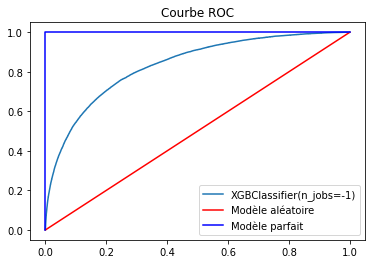

In [14]:
m.show_ROC()

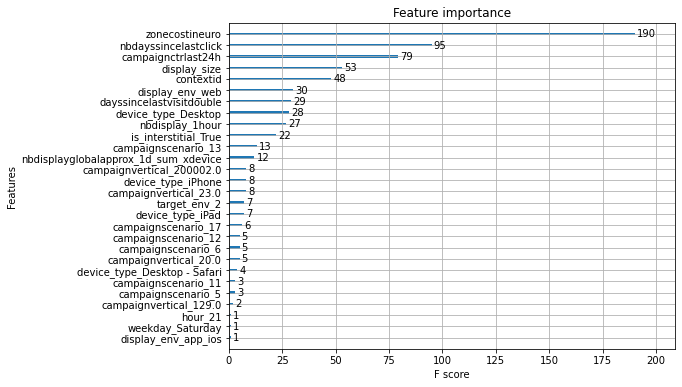

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))
m.plot_importance(ax=ax)

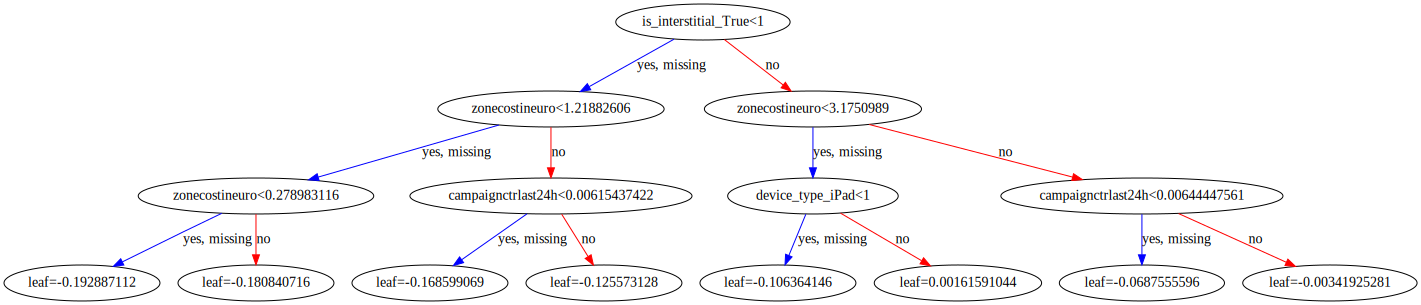

In [16]:
m.show_graph()

## Tuning des hyperparamètres avec GridSearchCV

On calcule le GridSearchCV sur un dataset plus petit pour avoir un temps de calcul raisonnable.

### Calcul et sauvegarde

https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn

In [17]:
model = XGBClassifier(booster='gbtree', objective='binary:logistic', n_jobs=1)

cv_params = {
        'n_estimators': [50, 100, 150, 200, 300],    
        'max_depth': [2, 4, 6, 8, 10],
        'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'min_child_weight': [1, 3, 5, 10],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],    
        'scale_pos_weight': [1, 16.5]   # A typical value to consider: sum(negative instances) / sum(positive instances)
        }

print(len(ParameterGrid(cv_params)))

54000


In [18]:
# SearchCV(model, cv_params, data_frac=0.01, random=True, n_iter=100, random_state=0)

### Restauration des résultats

In [19]:
dico, results = restauration_CV('XGBoost_CV_Randomized100_54000_0.01')

model : XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
model_name : XGBoost
type : RandomizedSearchCV
len_grid : 54000
n_iter : 100
data_frac : 0.01
temps : 00:01:31
params : {'n_estimators': [50, 100, 150, 200, 300], 'max_depth': [2, 4, 6, 8, 10], 'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3], 'gamma': [0.5, 1, 1.5, 2, 5], 'min_child_weight': [1, 3, 5, 10], 'subsample': [0.6, 0.8, 1.0], 'colsample_bytree': [0.6, 0.8, 1.0], 'scale_pos_weight': [1, 16.5]}
scoring : ['f1', 'recall', 'precision']


In [20]:
results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_scale_pos_weight,param_n_estimators,param_min_child_weight,param_max_depth,param_learning_rate,...,params,mean_test_f1,std_test_f1,rank_test_f1,mean_test_recall,std_test_recall,rank_test_recall,mean_test_precision,std_test_precision,rank_test_precision
0,4.532715,0.024173,0.033062,0.002823,0.6,1,200,5,2,0.2,...,"{'subsample': 0.6, 'scale_pos_weight': 1, 'n_e...",0.168306,0.033308,75,0.100921,0.021583,75,0.520812,0.104667,21
1,20.484033,0.122100,0.109850,0.003036,0.6,16.5,300,1,6,0.2,...,"{'subsample': 0.6, 'scale_pos_weight': 16.5, '...",0.282912,0.019136,17,0.297133,0.019924,47,0.270068,0.019009,53
2,4.420890,0.176698,0.038347,0.002507,0.8,16.5,200,5,2,0.3,...,"{'subsample': 0.8, 'scale_pos_weight': 16.5, '...",0.269630,0.012012,27,0.644150,0.022654,18,0.170516,0.008159,78
3,4.443414,0.030677,0.042880,0.001981,1.0,16.5,50,5,10,0.001,...,"{'subsample': 1.0, 'scale_pos_weight': 16.5, '...",0.320972,0.020637,1,0.466740,0.024658,38,0.244724,0.017981,58
4,6.511666,0.103396,0.049367,0.003976,0.8,16.5,300,3,2,0.3,...,"{'subsample': 0.8, 'scale_pos_weight': 16.5, '...",0.275848,0.007031,24,0.615310,0.013067,25,0.177793,0.005093,76
5,28.522105,0.204762,0.119939,0.006096,0.8,1,300,10,8,0.2,...,"{'subsample': 0.8, 'scale_pos_weight': 1, 'n_e...",0.214051,0.024394,54,0.141915,0.014373,55,0.437199,0.069768,38
6,4.489042,0.069400,0.033203,0.001950,0.8,16.5,150,3,2,0.3,...,"{'subsample': 0.8, 'scale_pos_weight': 16.5, '...",0.266976,0.009946,31,0.655242,0.015891,13,0.167687,0.007248,80
7,8.752622,0.036686,0.051362,0.001992,0.8,1,200,3,4,0.01,...,"{'subsample': 0.8, 'scale_pos_weight': 1, 'n_e...",0.098840,0.020638,91,0.054346,0.012453,91,0.572571,0.051303,7
8,5.108154,0.073508,0.035787,0.001991,0.8,1,50,3,8,0.2,...,"{'subsample': 0.8, 'scale_pos_weight': 1, 'n_e...",0.208289,0.021666,57,0.131958,0.013114,58,0.503172,0.090599,27
9,3.278263,0.026364,0.031492,0.002401,0.8,1,50,5,6,0.1,...,"{'subsample': 0.8, 'scale_pos_weight': 1, 'n_e...",0.153630,0.034168,78,0.089847,0.021628,78,0.545101,0.092724,14


**Graphiques XY avec 2 scores**

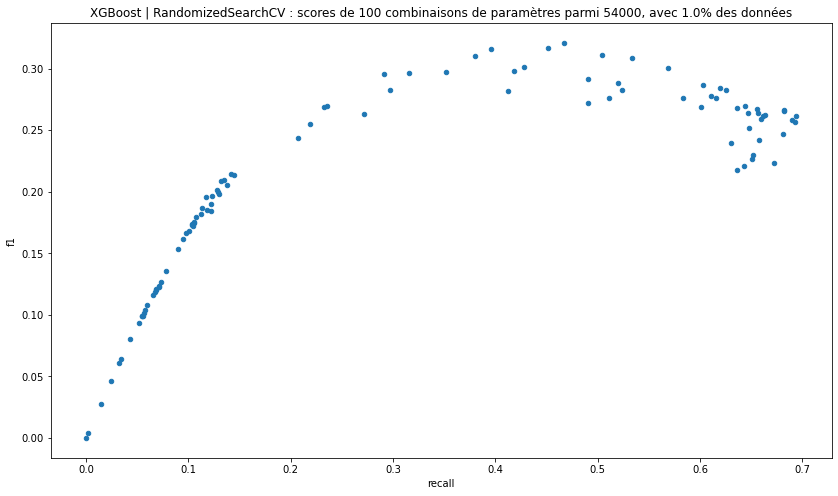

In [21]:
graph_2scores_CV(dico, results, 'recall', 'f1', s=20)

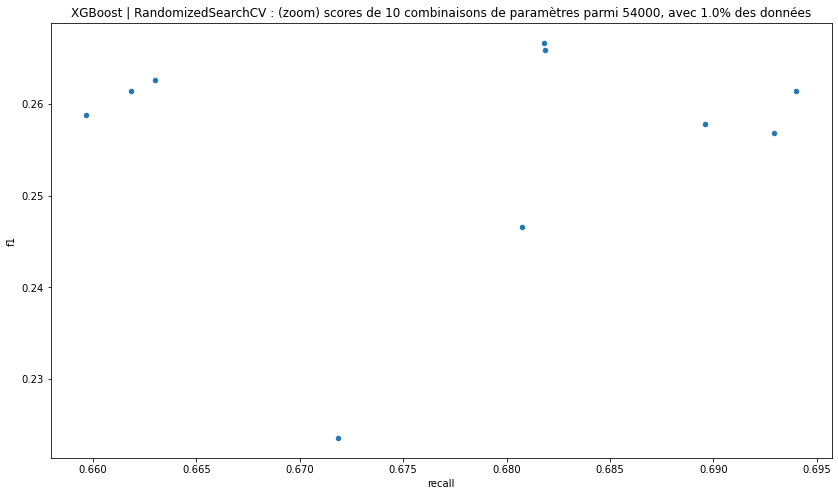

In [22]:
graph_2scores_CV(dico, results, 'recall', 'f1', s=20, zoom=0.1)

**Graphiques de l'effet des paramètres**

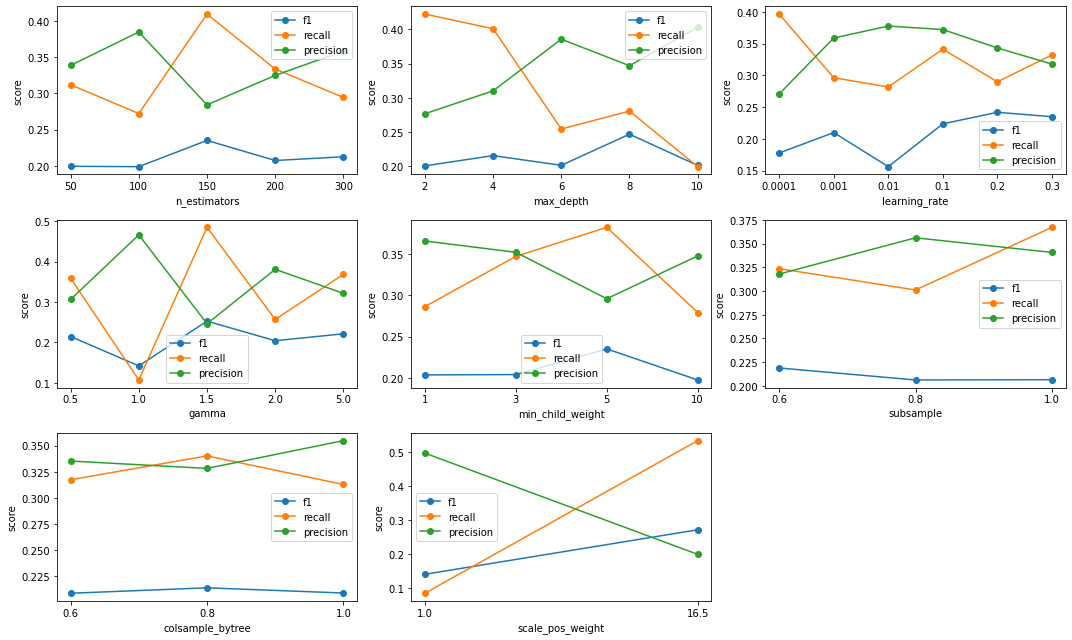

In [23]:
graph_param_CV(dico, results)

**Paramètres donnant le meilleur score**

In [24]:
best_params = best_score_CV(dico, results, 'recall')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_scale_pos_weight,param_n_estimators,param_min_child_weight,param_max_depth,param_learning_rate,...,params,mean_test_f1,std_test_f1,rank_test_f1,mean_test_recall,std_test_recall,rank_test_recall,mean_test_precision,std_test_precision,rank_test_precision
80,4.159816,0.123288,0.032181,0.000515,0.6,16.5,150,1,2,0.1,...,"{'subsample': 0.6, 'scale_pos_weight': 16.5, '...",0.261429,0.009564,39,0.694009,0.010264,1,0.161091,0.006967,87
20,1.418101,0.068761,0.021916,0.000637,0.8,16.5,50,3,2,0.3,...,"{'subsample': 0.8, 'scale_pos_weight': 16.5, '...",0.256848,0.008305,42,0.692934,0.017915,2,0.157663,0.005622,90
82,2.435630,0.024635,0.028198,0.001507,1.0,16.5,100,10,2,0.1,...,"{'subsample': 1.0, 'scale_pos_weight': 16.5, '...",0.257821,0.007138,41,0.689601,0.015222,3,0.158571,0.004935,89
37,4.526614,0.133069,0.032211,0.000585,0.8,16.5,150,10,2,0.2,...,"{'subsample': 0.8, 'scale_pos_weight': 16.5, '...",0.265894,0.005413,33,0.681854,0.015944,4,0.165177,0.003926,83
11,16.911438,0.152336,0.098394,0.008215,0.6,16.5,300,5,4,0.01,...,"{'subsample': 0.6, 'scale_pos_weight': 16.5, '...",0.266674,0.011627,32,0.681829,0.016461,5,0.165781,0.008126,81
64,8.297189,0.240190,0.060218,0.021102,0.6,16.5,300,1,2,0.01,...,"{'subsample': 0.6, 'scale_pos_weight': 16.5, '...",0.246549,0.011615,45,0.680724,0.035931,6,0.150546,0.007001,92
72,10.546210,0.129263,0.049542,0.004273,0.8,16.5,200,5,4,0.0001,...,"{'subsample': 0.8, 'scale_pos_weight': 16.5, '...",0.223574,0.012632,51,0.671829,0.020461,7,0.134162,0.008568,97
63,2.068807,0.046176,0.026231,0.000453,1.0,16.5,100,5,2,0.3,...,"{'subsample': 1.0, 'scale_pos_weight': 16.5, '...",0.262659,0.008122,37,0.663002,0.017061,8,0.163787,0.005513,85
54,2.509483,0.107517,0.028550,0.004648,1.0,16.5,50,1,4,0.1,...,"{'subsample': 1.0, 'scale_pos_weight': 16.5, '...",0.261457,0.013206,38,0.661848,0.024775,9,0.162924,0.008859,86
14,2.462782,0.049676,0.026051,0.000545,0.6,16.5,50,10,4,0.01,...,"{'subsample': 0.6, 'scale_pos_weight': 16.5, '...",0.258811,0.011115,40,0.659669,0.027457,10,0.161020,0.007333,88


{'subsample': 0.6,
 'scale_pos_weight': 16.5,
 'n_estimators': 150,
 'min_child_weight': 1,
 'max_depth': 2,
 'learning_rate': 0.1,
 'gamma': 2,
 'colsample_bytree': 0.8}

**Analyse sur la base complète**

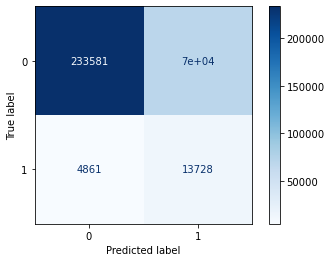

f1 : 0.2685
recall : 0.7385
negative predictive value : 0.9796
precision : 0.1641
roc_auc : 0.8331
Wall time: 1min 8s


In [25]:
%%time
m = Modelisation(X, y, XGBClassifier(**best_params, n_jobs=-1), scaling=False)
m.show_conf_matrix()
m.show_metrics_score()

Le recall est moins bon que celui trouvé auparavant. Essayons avec le `learning_rate` par défaut.

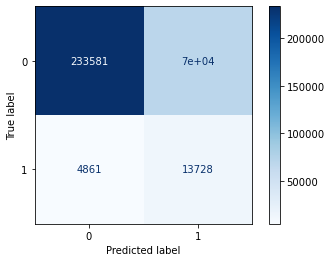

f1 : 0.2685
recall : 0.7385
negative predictive value : 0.9796
precision : 0.1641
roc_auc : 0.8331
Wall time: 1min 12s


In [26]:
%%time
if 'learning_rate' in best_params:
    del best_params['learning_rate']
m = Modelisation(X, y, XGBClassifier(**best_params, n_jobs=-1), scaling=False)
m.show_conf_matrix()
m.show_metrics_score()

Nous reproduisons le graphique f1 vs recall en prenant 10% des meilleures combinaisons (selon le recall), en fittant le modèle sur 10% des données.

In [27]:
# %%time

# df_small = pd.read_csv('data/df_train_prepro.csv').sample(frac=0.1)
# datasets_df_small = datasets(df_small, verbose=False)
# X_small = datasets_df_small['X']
# y_small = datasets_df_small['y']

# f1_list = []
# recall_list = []
# params_list = []


# nb_tot = 500
# nb = 50

# random.seed(1)
# sample = random.sample(list(range(nb_tot)), nb)
# for j in trange(nb):
#     i = sample[j]
#     params = results_sort.iloc[i].params
#     m = Modelisation(X_small, y_small, XGBClassifier(**params, n_jobs=-1), scaling=False)
#     params_list.append(params)
#     f1_list.append(m.metrics_score['f1'])
#     recall_list.append(m.metrics_score['recall'])
    
# plt.figure(figsize=(14, 8))
# plt.scatter(recall_list, f1_list, marker='o')
# plt.xlabel('recall')
# plt.ylabel('f1')
# plt.show()
 
# # dico_ = {'params': params_list, 'f1': f1_list, 'recall': recall_list}     
# # r = pd.DataFrame(dico_).sort_values(by='recall', ascending=False)

Même graphique avec le `learning_rate` par défaut :

In [28]:
# %%time

# sample = random.sample(list(range(nb_tot)), nb)
# for j in trange(nb):
#     i = sample[j]
#     params = results_sort.iloc[i].params
#     if 'learning_rate' in params:
#         del params['learning_rate']
#     m = Modelisation(X_small, y_small, XGBClassifier(**params, n_jobs=-1), scaling=False)
#     params_list.append(params)
#     f1_list.append(m.metrics_score['f1'])
#     recall_list.append(m.metrics_score['recall'])
    
# plt.figure(figsize=(14, 8))
# plt.scatter(recall_list, f1_list, marker='o')
# plt.xlabel('recall')
# plt.ylabel('f1')
# plt.show()

**Test de paramètres**

In [29]:
params = {'colsample_bytree': 1.0, 
          'gamma': 1,
          'min_child_weight': 15,
          'scale_pos_weight': 16.5, 
          'subsample': 0.8}

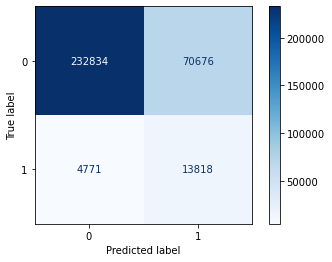

f1 : 0.2681
recall : 0.7433
negative predictive value : 0.9799
precision : 0.1635
roc_auc : 0.8351
Wall time: 1min 25s


In [30]:
%%time
m = Modelisation(X, y, XGBClassifier(**params, n_jobs=-1), scaling=False)
m.show_conf_matrix()
m.show_metrics_score()

## Oversampling

In [31]:
df_train_res = pd.read_csv('data/df_train_res.csv').sample(frac=1)
df_test_res = pd.read_csv('data/df_test_res.csv').sample(frac=1)

datasets_df_train_res = datasets(df_train_res, verbose=False)
X_train_res = datasets_df_train_res['X']
y_train_res = datasets_df_train_res['y']

datasets_df_test_res = datasets(df_test_res, verbose=False)
X_test_res = datasets_df_test_res['X']
y_test_res = datasets_df_test_res['y']

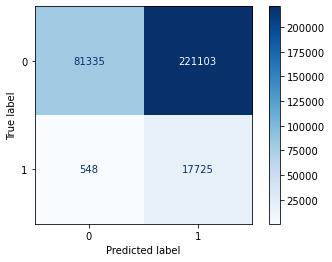

f1 : 0.1379
recall : 0.9700
negative predictive value : 0.9933
precision : 0.0742
roc_auc : 0.8087
Wall time: 3min


In [32]:
%%time
m = Modelisation(X_train_res, y_train_res, XGBClassifier(**params, n_jobs=-1), X_test=X_test_res, y_test=y_test_res, scaling=False)
m.show_conf_matrix()
m.show_metrics_score()

In [33]:
# SearchCV(model, cv_params, data_frac=0.01, random=True, n_iter=100, csv='data/df_train_res.csv', name='res', random_state=0)

Problème du gridsearchCV ici, les tests sont effectués sur des données oversamplées, donc les métriques sont faussées.

In [34]:
dico, results = restauration_CV('XGBoost_CV_Randomized100_54000_0.01_res')

model : XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
model_name : XGBoost
type : RandomizedSearchCV
len_grid : 54000
n_iter : 100
data_frac : 0.01
temps : 00:02:40
params : {'n_estimators': [50, 100, 150, 200, 300], 'max_depth': [2, 4, 6, 8, 10], 'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3], 'gamma': [0.5, 1, 1.5, 2, 5], 'min_child_weight': [1, 3, 5, 10], 'subsample': [0.6, 0.8, 1.0], 'colsample_bytree': [0.6, 0.8, 1.0], 'scale_pos_weight': [1, 16.5]}
scoring : ['f1', 'recall', 'precision']


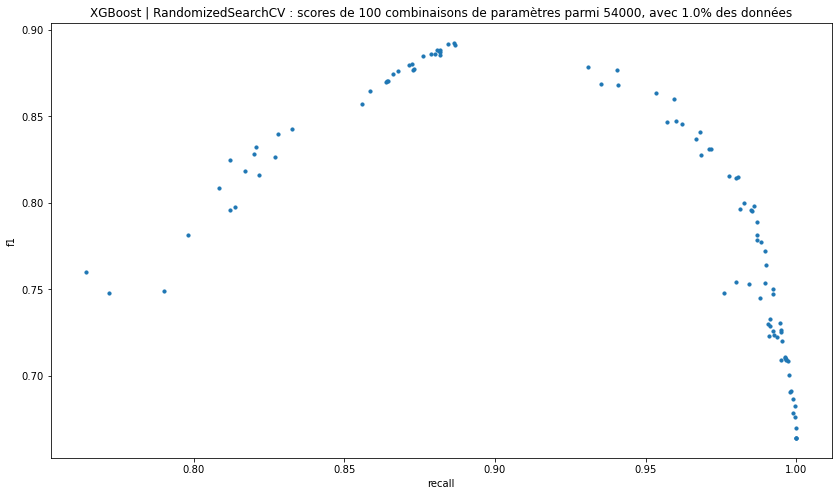

In [35]:
graph_2scores_CV(dico, results, 'recall', 'f1', s=10)

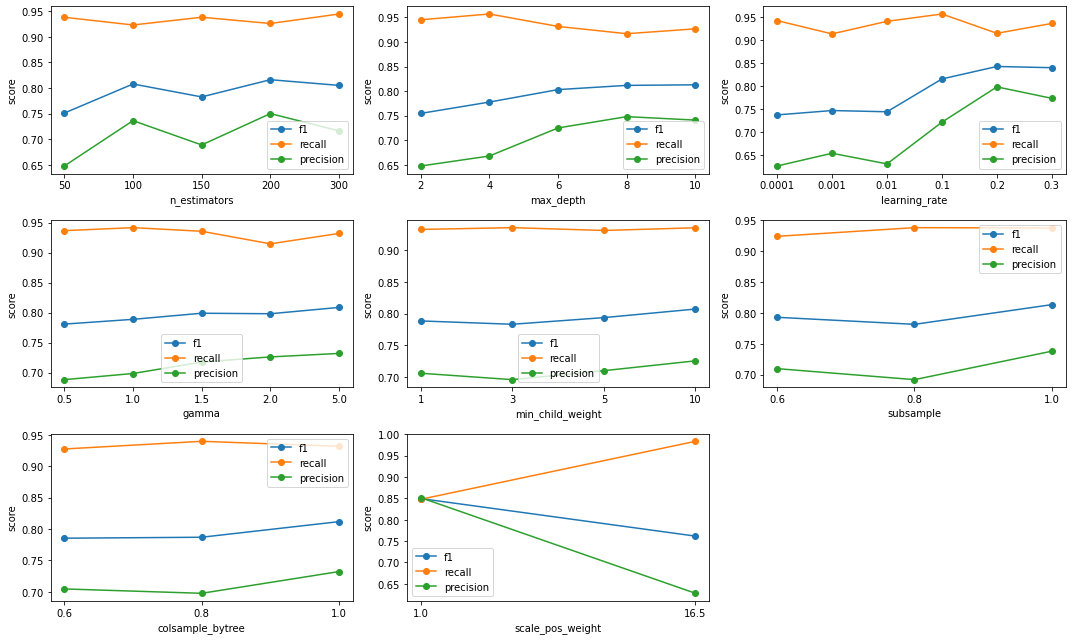

In [36]:
graph_param_CV(dico, results)

In [37]:
best_params = best_score_CV(dico, results, 'recall')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_scale_pos_weight,param_n_estimators,param_min_child_weight,param_max_depth,param_learning_rate,...,params,mean_test_f1,std_test_f1,rank_test_f1,mean_test_recall,std_test_recall,rank_test_recall,mean_test_precision,std_test_precision,rank_test_precision
50,6.960311,0.147749,0.050453,0.007027,0.8,16.5,200,3,2,0.0001,...,"{'subsample': 0.8, 'scale_pos_weight': 16.5, '...",0.664071,0.000069,98,1.000000,0.000000,1,0.497086,0.000077,98
75,2.734533,0.058760,0.035880,0.001165,1.0,16.5,50,3,4,0.0001,...,"{'subsample': 1.0, 'scale_pos_weight': 16.5, '...",0.670086,0.001040,97,1.000000,0.000000,1,0.503857,0.001175,97
72,11.987065,0.123323,0.055391,0.001941,0.8,16.5,300,5,2,0.0001,...,"{'subsample': 0.8, 'scale_pos_weight': 16.5, '...",0.664071,0.000069,98,1.000000,0.000000,1,0.497086,0.000077,98
46,6.433679,0.030979,0.040941,0.001220,0.6,16.5,150,1,2,0.0001,...,"{'subsample': 0.6, 'scale_pos_weight': 16.5, '...",0.664071,0.000069,98,1.000000,0.000000,1,0.497086,0.000077,98
41,11.782135,0.202407,0.085459,0.001010,1.0,16.5,150,1,6,0.001,...,"{'subsample': 1.0, 'scale_pos_weight': 16.5, '...",0.682418,0.002106,94,0.999501,0.000407,5,0.518069,0.002388,94
54,2.933330,0.052043,0.035336,0.000583,0.8,16.5,50,3,4,0.001,...,"{'subsample': 0.8, 'scale_pos_weight': 16.5, '...",0.676253,0.003701,96,0.999501,0.000806,6,0.511007,0.004371,96
0,4.548964,0.052744,0.034728,0.000529,0.8,16.5,100,3,2,0.01,...,"{'subsample': 0.8, 'scale_pos_weight': 16.5, '...",0.678773,0.003194,95,0.999002,0.000771,7,0.514019,0.003807,95
49,4.317597,0.093706,0.042750,0.000923,0.8,16.5,50,5,6,0.0001,...,"{'subsample': 0.8, 'scale_pos_weight': 16.5, '...",0.686575,0.004713,93,0.998753,0.000872,8,0.523103,0.005703,93
79,14.047357,0.247306,0.073106,0.001324,0.8,16.5,200,3,4,0.001,...,"{'subsample': 0.8, 'scale_pos_weight': 16.5, '...",0.691046,0.002020,91,0.998088,0.001103,9,0.528479,0.002586,91
65,3.622495,0.092771,0.033892,0.001932,0.8,16.5,50,10,4,0.0001,...,"{'subsample': 0.8, 'scale_pos_weight': 16.5, '...",0.690647,0.001416,92,0.998004,0.000963,10,0.528033,0.001863,92


{'subsample': 0.8,
 'scale_pos_weight': 16.5,
 'n_estimators': 200,
 'min_child_weight': 3,
 'max_depth': 2,
 'learning_rate': 0.0001,
 'gamma': 2,
 'colsample_bytree': 0.6}

C:\Users\pasqu\Informatique\statapp\tools.py:136: RuntimeWarning: invalid value encountered in longlong_scalars
  NPV = TN / (TN + FN)


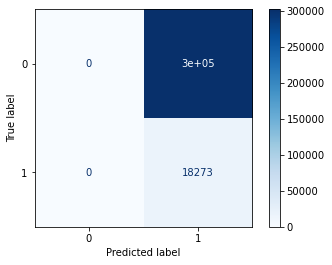

f1 : 0.1078
recall : 1.0000
negative predictive value : nan
precision : 0.0570
roc_auc : 0.7821
Wall time: 2min 29s


In [38]:
%%time
m = Modelisation(X_train_res, y_train_res, XGBClassifier(**best_params, n_jobs=-1), X_test=X_test_res, y_test=y_test_res, scaling=False)
m.show_conf_matrix()
m.show_metrics_score()

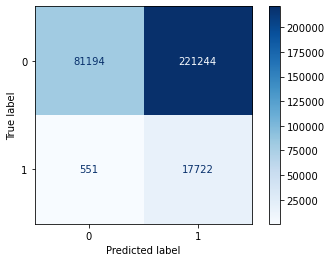

f1 : 0.1378
recall : 0.9698
negative predictive value : 0.9933
precision : 0.0742
roc_auc : 0.8133
Wall time: 2min 27s


In [39]:
%%time
if 'learning_rate' in best_params:
    del best_params['learning_rate']
m = Modelisation(X_train_res, y_train_res, XGBClassifier(**best_params, n_jobs=-1), X_test=X_test_res, y_test=y_test_res, scaling=False)
m.show_conf_matrix()
m.show_metrics_score()

In [40]:
print(f"Temps d'exécution total : {time.strftime('%H:%M:%S', time.gmtime(time.time()-t))}")

Temps d'exécution total : 00:15:10
